In [1]:
# import all modules here
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
from scipy.special import jv # bessel function of the first kind
import seaborn as sns
sns.set()
sns.set_style("white")

%load_ext autoreload
%autoreload 2
import floquet as fl

In [161]:
# define all variables
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# hbar is a global variable
hbar = 0.6582119569 # ev * fs

# these are parameters
v = 3.6/hbar # Ang/fs
Omega = 0.12/hbar # fs^-1
Tpump = 106.16 # fs
Tprobe = 26 # fs
eE0 = 7.5e-3 # eV / Ang
mu = 0.3 # eV
wf = mu/hbar # fs^-1

# $I(\omega)$

In [162]:
# function that diagonalizes Ephi=H0phi for IC of Dirac ODE
def Hbite(kx,ky,A2,D2,mu):
    H = A2*ky*s1 - A2*kx*s2 + D2*(kx**2+ky**2)*s0 - mu*s0 #+ 0/2*(kx**2+ky**2)**(3/2)*np.cos(np.arctan(ky/kx))*s3
    return H

def InitialConditions(kx,ky,A2,D2,mu):
    """
    Returns phi and E for the time-independent Hamiltonian
    phi[:,alpha] is the alpha'th eigenvector
    """
    # initial Hamiltonian
    hk = Hbite(kx,ky,A2,D2,mu)
    
    # diagonalize it
    E, phi = np.linalg.eigh(hk)
    
    return E, phi

In [5]:
# function f in dt{psi} = f(t,psi)
def dirac(t,psi,kx,ky,A2,D2,mu,eE0,Omega,Tpump,polarization="circ"):
    # add peierls momentum
    kx_bump = -eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.cos(Omega*t) / hbar # important to divide by hbar since sub is hbar*k -> eA
    ky_bump = eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.sin(Omega*t) / hbar
    # get H
    if polarization == "circ":
        H = Hbite(kx+kx_bump,ky+ky_bump,A2,D2,mu)
    elif polarization == "lin":
        H = Hbite(kx+kx_bump,ky,A2,D2,mu)
    # return schrodinger
    f = -1j/hbar * H @ psi
    return f

In [6]:
# enveloppe and fermi functions. 
# the latter is functionally irrelevant as we consider low T
def Enveloppe(t,t0,Tprobe):
    """
    Probe pulse enveloppe function
    """
    return np.exp(-(t-t0)**2/(2*Tprobe**2))

def Fermi(E,kT):
    """
    Fermi distribution
    """
    if kT==0:
        return np.heaviside(-E,0.5)
    else:
        f = 1/(np.exp(E/kT) + 1)
    return f

In [94]:
# workhorses

# integrates s(t,t0)*e^{iwt}*psi_{alpha,s}(t) and modulus squared
# this is the heart of the program
def PhotocurrentSA(psi,s,kx,ky,w,t0,eE0,Omega,Tpump,Tprobe):
    # t-space
    t_space = psi.t
    # integrand: enveloppe * phase * psi
    integrand = Enveloppe(t_space,t0,Tprobe) * np.exp(1j*w*t_space) * psi.y[s,:]
    # integrate samples data using simpson's rule
    I = simpson(integrand,x=t_space)
    return np.abs(I)**2

# main function
def Photocurrent(psi_plus,psi_minus,kx,ky,Es,w,t0,eE0,Omega,Tpump,Tprobe):
    """
    Main photocurrent function
    Es[i] corresponds to the energy of the minus (i=0) or plus (i=1) psi
    """
    # the phis are solved for in the main looping function (30/01/23 change)
    
    # integrate and add it up
    P = 0
    for s in range(2):
        # add up both spins
        P += Fermi(Es[0],kT=0) * PhotocurrentSA(psi_minus,s=s,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe) 
        P += Fermi(Es[1],kT=0) * PhotocurrentSA(psi_plus,s=s,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
    return P

# function to help plotting and making arrays to visualize
def PhotocurrentArrayEnergy(res_w,w_range,kx,ky,t0,A2,D2,mu,eE0,Omega,Tpump,Tprobe,polarization="circ"):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(-w_range,w_range,res_w) #- mu/hbar #np.linspace(-np.pi,np.pi,res_w)*Omega - mu/hbar # from inverting (w-wF)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions(kx,ky,A2,D2,mu)

    # solve the dirac equation
    # the bounds in time are set by taking ts beyond the largest time scales
    if polarization == "circ":
        psi_plus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,A2,D2,mu,eE0,Omega,Tpump), method='RK45')
        psi_minus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,A2,D2,mu,eE0,Omega,Tpump), method='RK45')
    elif polarization == "lin":
        psi_plus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,A2,D2,mu,eE0,Omega,Tpump,"lin"), method='RK45')
        psi_minus = solve_ivp(fun=dirac, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,A2,D2,mu,eE0,Omega,Tpump,"lin"), method='RK45')
    
    # compute Photocurrent
    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent(psi_plus=psi_plus,psi_minus=psi_minus,Es=Es,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [95]:
ws5, Ps5 = PhotocurrentArrayEnergy(res_w=300,w_range=1,kx=0.0,ky=0,t0=-500,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization="circ")
ws1, Ps1 = PhotocurrentArrayEnergy(res_w=300,w_range=1,kx=0.0,ky=0,t0=-100,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization="circ")
ws0, Ps0 = PhotocurrentArrayEnergy(res_w=300,w_range=1,kx=0.0,ky=0,t0=0,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization="circ")

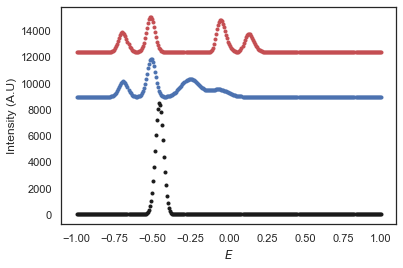

In [98]:
# plot it
plt.figure()

plt.scatter(ws5,Ps5,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5) + 500

plt.scatter(ws1,Ps1+shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1) + 500

plt.scatter(ws0,Ps0+shift2,c='r',marker='.',label=r"$t_0 = 0$")

# plt.legend()
# plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.xlabel(r"$E$")
plt.ylabel(r"Intensity (A.U)")
# plt.xlim(-1,1)
plt.show()

# Analytic $I(\omega)$ model

In [99]:
def PhotocurrentAnalytic(w,t0,A2,D2,mu,eE0,Omega,Tpump,Tprobe):
    """
    Analytic expression for photocurrent
    """
    a0 = eE0/(hbar*Omega) * np.exp(-t0**2/(2*Tpump**2))
    Eeff = np.sqrt((A2*a0)**2 + (hbar*Omega/2)**2)
    az = (hbar*Omega/2) / Eeff
    
    I = 0
    
    for s in [-1,1]:
        for beta in [-1,1]:
            exp = np.exp(-Tprobe**2 * (w - Omega*beta/2 - D2*a0**2/hbar - Eeff*s/hbar + mu/hbar)**2)
            fac = (1 - s*beta*az)/2
#             print(-Tprobe**2*(w + Omega/2*beta - E0/hbar + s*Eeff/hbar))
            I += fac*exp
            
    
    fermi = Fermi(-mu,0) # we know that E at Gamma is -mu
    I *= 2*np.pi*Tprobe**2 * fermi
    
    return I

def PhotocurrentArrayAnalytic(res_w,w_range,t0,A2,D2,mu,eE0,Omega,Tpump,Tprobe):
    ws = np.linspace(-w_range,w_range,res_w) #- mu/hbar # to get frequencies
    Is = np.zeros(res_w)
    
    for i,w in enumerate(ws):
        Is[i] = PhotocurrentAnalytic(w=w,t0=t0,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
        
    return ws,Is

In [104]:
D2 = 30.4

ws5, Ps5 = PhotocurrentArrayEnergy(res_w=300,w_range=1,kx=0.0,ky=0,t0=-500,A2=3.33,D2=D2,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1, Ps1 = PhotocurrentArrayEnergy(res_w=300,w_range=1,kx=0.0,ky=0,t0=-100,A2=3.33,D2=D2,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws0, Ps0 = PhotocurrentArrayEnergy(res_w=300,w_range=1,kx=0.0,ky=0,t0=0,A2=3.33,D2=D2,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

In [105]:
ws_5,Is_5=PhotocurrentArrayAnalytic(res_w=1000,w_range=1,t0=-500,A2=3.33,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws_1,Is_1=PhotocurrentArrayAnalytic(res_w=1000,w_range=1,t0=-100,A2=3.33,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws_0,Is_0=PhotocurrentArrayAnalytic(res_w=1000,w_range=1,t0=0,A2=3.33,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

In [108]:
%matplotlib notebook

# plot it
plt.figure()

plt.plot(ws_5,Is_5,c='k',label=r"$t_0 = -500$")
plt.scatter(ws5,Ps5,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5) + 500

plt.scatter(ws1,Ps1+shift1,c='b',marker='.',label=r"$t_0 = -100$")
plt.plot(ws_1,Is_1+shift1,c='k',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1) + 500

plt.scatter(ws0,Ps0+shift2,c='r',marker='.',label=r"$t_0 = 0$")
plt.plot(ws_0,Is_0+shift2,c='k',label=r"$t_0 = 0$")
# plt.legend()
# plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.xlabel(r"$\omega$")
plt.ylabel(r"Intensity (A.U)")

# a0 = eE0/(hbar*Omega) * np.exp(-0**2/(2*Tpump**2))
# Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
# plt.axvline(Omega/2 + Eeff/hbar)
# ws = np.linspace(-0.5,0.5,1000)
# peak = np.exp(-Tprobe**2 * (ws + Omega/2 - D2*a0**2/hbar - Eeff/hbar)**2)*2*np.pi*Tprobe**2
# plt.scatter(ws,peak,c='pink')

# plt.xlim(-1,1)
plt.show()

<IPython.core.display.Javascript object>

# $I(\omega,k_x)$

In [8]:
# tool to help plot labels in the right places
def coord_to_res(x,x_up,x_low,res):
    """
    translates physical value (kx = 0) to pixel (res/2)
    linear scaling compatible only
    """
    m = (res-1)/(x_up-x_low)
    b = -m * x_low
    return m*x+b

## Circular polarization

In [9]:
def PhotocurrentArrayWK(k_dir,k_other,k_range,w_range,t0,A2,D2,mu,eE0,Omega,Tpump,Tprobe,polarization="circ"):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 100
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(-k_range,k_range,res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergy(res_w=res_w,w_range=w_range,kx=kx,ky=k_other,t0=t0,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization=polarization)[1] # second component is ps
            
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergy(res_w=res_w,w_range=w_range,kx=k_other,ky=ky,t0=t0,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization=polarization)[1] # second component is ps
        
    return P

In [109]:
P = PhotocurrentArrayWK(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=-500,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


<IPython.core.display.Javascript object>


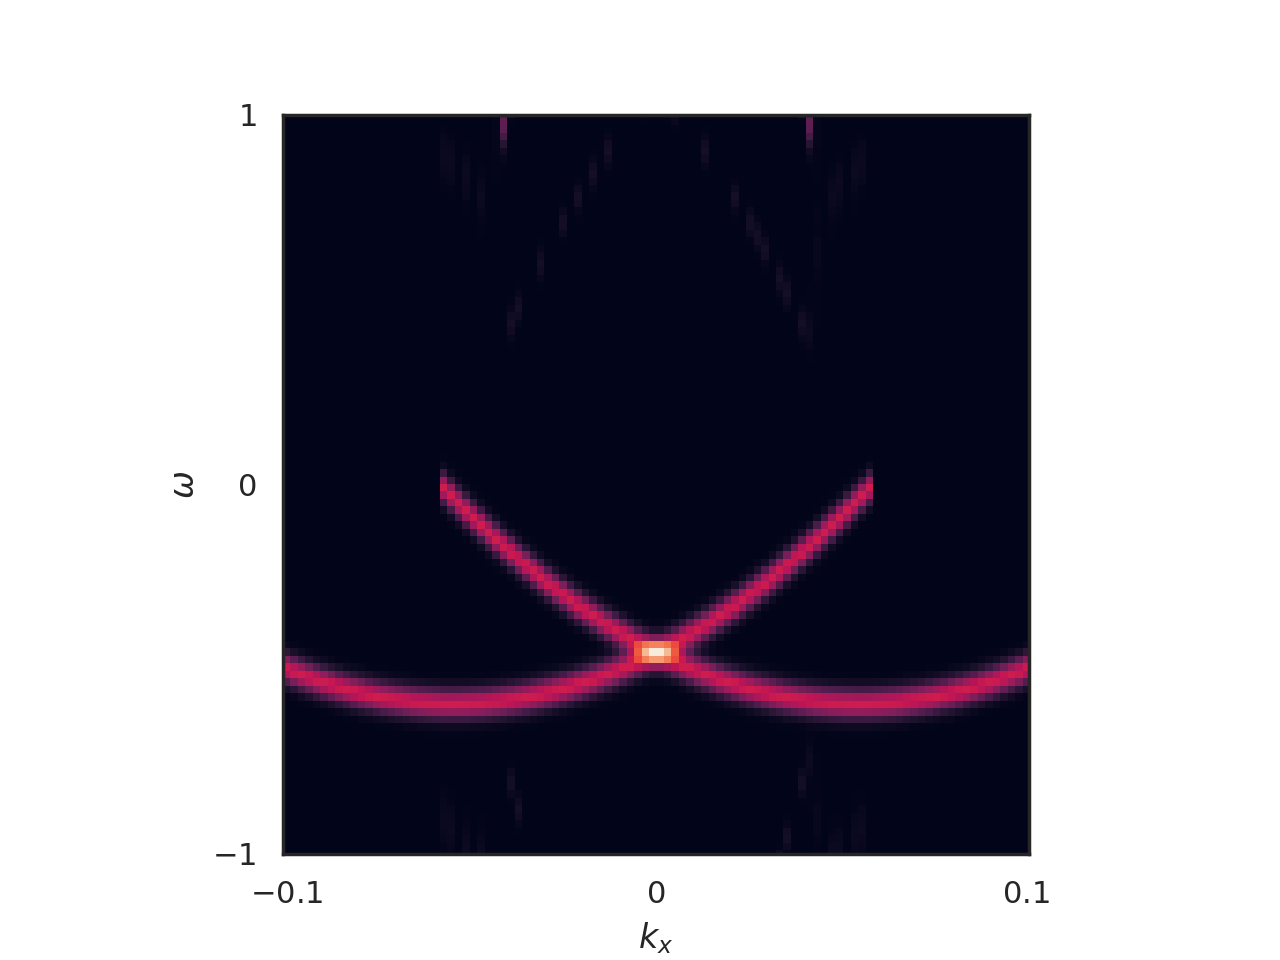

In [112]:
%matplotlib notebook
plt.imshow(P.T)
plt.xticks([coord_to_res(-0.1,0.1,-0.1,100),coord_to_res(-0.,0.1,-0.1,100),coord_to_res(0.1,0.1,-0.1,100)],labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks([coord_to_res(-1,1,-1,100),coord_to_res(0,1,-1,100),coord_to_res(1,1,-1,100)],labels=[r"$-1$",r"$0$",r"$1$"])
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.ylim(0,99)
plt.show()

In [113]:
P_100 = PhotocurrentArrayWK(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=-100,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


<IPython.core.display.Javascript object>


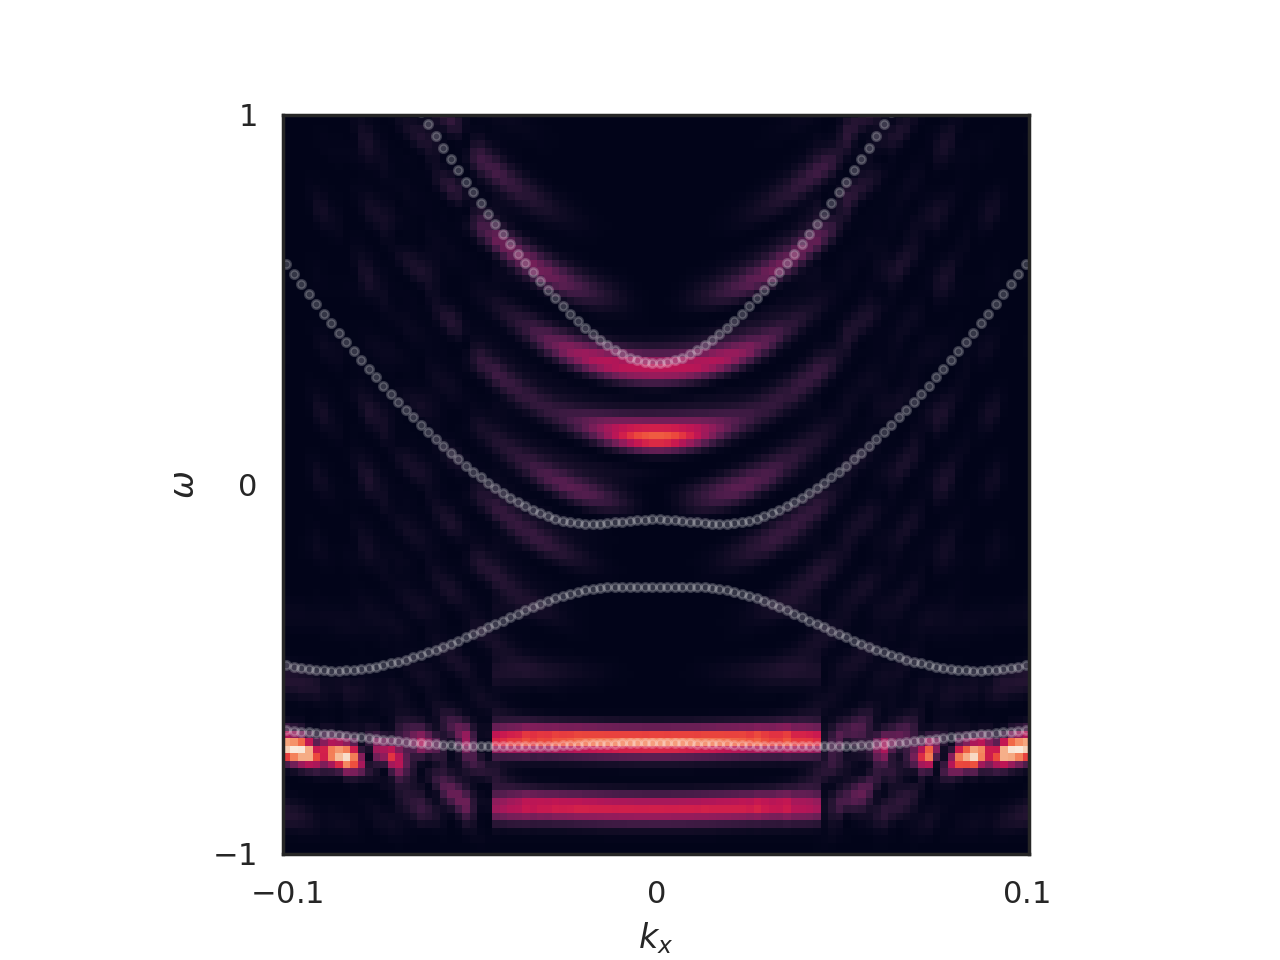

In [117]:
%matplotlib notebook
plt.imshow(P_100.T)
plt.xticks([coord_to_res(-0.1,0.1,-0.1,100),coord_to_res(-0.,0.1,-0.1,100),coord_to_res(0.1,0.1,-0.1,100)],labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks([coord_to_res(-1,1,-1,100),coord_to_res(0,1,-1,100),coord_to_res(1,1,-1,100)],labels=[r"$-1$",r"$0$",r"$1$"])
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.ylim(0,99)
plt.show()

In [115]:
P_0 = PhotocurrentArrayWK(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=-0,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


<IPython.core.display.Javascript object>


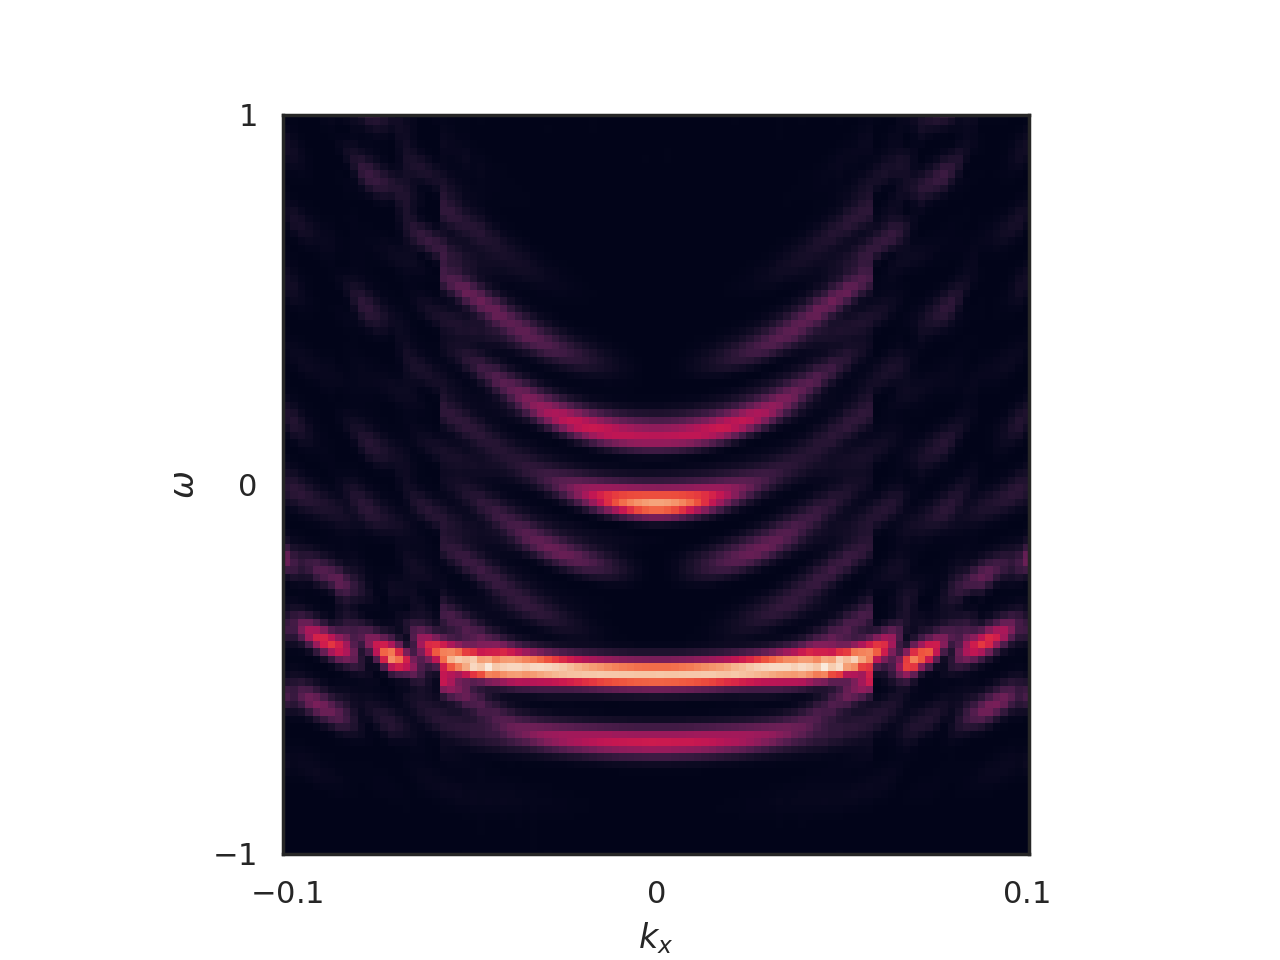

In [116]:
%matplotlib notebook
plt.imshow(P_0.T)
plt.xticks([coord_to_res(-0.1,0.1,-0.1,100),coord_to_res(-0.,0.1,-0.1,100),coord_to_res(0.1,0.1,-0.1,100)],labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks([coord_to_res(-1,1,-1,100),coord_to_res(-0.,1,-1,100),coord_to_res(1,1,-1,100)],labels=[r"$-1$",r"$0$",r"$1$"])

# a0 = eE0/(hbar*Omega)
# Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
# plt.axhline(coord_to_res(30.4*a0**2/hbar - Omega/2 + Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar - Omega/2 - Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar + Omega/2 + Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar + Omega/2 - Eeff/hbar,1,-1,100))

plt.ylim(0,99)
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.show()

In [309]:
# plot the floquet spectrum over the photocurrent
ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=10,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega)


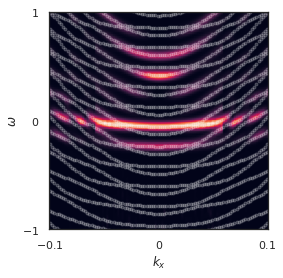

In [313]:
plt.imshow(P_0.T)

plt.scatter(coord_to_res(ks_floquet,0.1,-0.1,100),coord_to_res(Es_floquet/hbar+mu/hbar,1,-1,100),marker='.',c='white',alpha=0.2)

plt.xticks([coord_to_res(-0.1,0.1,-0.1,100),coord_to_res(-0.,0.1,-0.1,100),coord_to_res(0.1,0.1,-0.1,100)],labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks([coord_to_res(-1,1,-1,100),coord_to_res(-0.,1,-1,100),coord_to_res(1,1,-1,100)],labels=[r"$-1$",r"$0$",r"$1$"])

# a0 = eE0/(hbar*Omega)
# Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
# plt.axhline(coord_to_res(30.4*a0**2/hbar - Omega/2 + Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar - Omega/2 - Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar + Omega/2 + Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar + Omega/2 - Eeff/hbar,1,-1,100))

plt.ylim(0,99)
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.show()

flat band after increasing $A_2$

In [418]:
A2_bend = 5.33
D2_bend = 50.
P_bend = PhotocurrentArrayWK(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=-0,A2=A2_bend,D2=D2_bend,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


In [419]:
ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=10,A2=A2_bend,D2=D2_bend,mu=0.3,eE0=eE0,Omega=Omega)


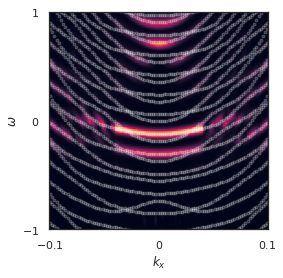

In [420]:
plt.imshow(P_bend.T)

plt.scatter(coord_to_res(ks_floquet,0.1,-0.1,100),coord_to_res(Es_floquet/hbar+mu/hbar,1,-1,100),marker='.',c='white',alpha=0.2)

plt.xticks([coord_to_res(-0.1,0.1,-0.1,100),coord_to_res(-0.,0.1,-0.1,100),coord_to_res(0.1,0.1,-0.1,100)],labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks([coord_to_res(-1,1,-1,100),coord_to_res(-0.,1,-1,100),coord_to_res(1,1,-1,100)],labels=[r"$-1$",r"$0$",r"$1$"])

# a0 = eE0/(hbar*Omega)
# Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
# plt.axhline(coord_to_res(-Omega,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar - Omega/2 - Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar + Omega/2 + Eeff/hbar,1,-1,100))
# plt.axhline(coord_to_res(30.4*a0**2/hbar + Omega/2 - Eeff/hbar,1,-1,100))

plt.ylim(0,99)
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.show()

## Plot along $k_y$

In [26]:
P_0_ky = PhotocurrentArrayWK(k_dir=2,k_other=0,k_range=0.1,w_range=1,t0=-0,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization="circ")


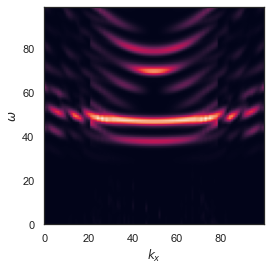

In [27]:
plt.imshow(P_0_ky.T)
# plt.xticks([coord_to_res(0,0.1,-0.1,100)])
plt.ylim(0,99)
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.show()

## Linear polarization (just to check)

In [144]:
P = PhotocurrentArrayWK(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=0,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe,polarization="lin")


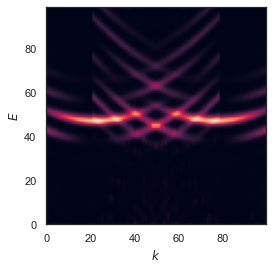

In [149]:
plt.imshow(P.T)
# plt.xticks([coord_to_res(0,0.1,-0.1,100)])
plt.ylim(0,99)
plt.xlabel("$k$")
plt.ylabel("$E$")
plt.show()

# Floquet Hamiltonian

In [132]:
from ipywidgets import interact

In [133]:
def Hfloquet(ms,kx,ky,A2,D2,mu,eE0,Omega):
    """
    Floquet Hamiltonian
    for ms = 1, include 0 and 1
    for ms = 2, include -1, 0, 1, and 2
    for ms = 3, include -2, -1, 0, 1, 2, and 3
    etc
    """
    # set a0
    a0 = eE0/(hbar*Omega)
    # size is ms x 2
    size = int(2*ms)
    
    # make diagonals
    diags = np.kron(np.eye(size), D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1) - mu*s0)
    diags_floquet = np.zeros((2*size,2*size),dtype=float)
    for i in range(size):
        m = ms - i
        diags_floquet[2*i:2*(i+1),2*i:2*(i+1)] = m*hbar*Omega * s0
        
    diag = diags + diags_floquet
    
    # make off-diagonals
    off_diag = np.kron(np.eye(size,k=+1), -D2*a0*(kx-1j*ky)*s0 - 1j*a0/2*A2*(s1-1j*s2))
    
    # matrix
    H = diag + off_diag + off_diag.conj().T
    
    return H

def Hfloquet0(kx,ky,A2,D2,mu,eE0,Omega):
    """
    Floquet Hamiltonian 4x4 with flat band at zero energy at gamma point
    """
    # set a0
    a0 = eE0/(hbar*Omega)
    
    H = np.zeros((4,4),dtype=complex)
    
    # make diagonals
    H[0:2,0:2] = D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1) + hbar*Omega*s0
    H[2:4,2:4] = D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1)
    
    # make off-diagonals
    off_diag = -D2*a0*(kx-1j*ky)*s0 - 1j*a0/2*A2*(s1-1j*s2)
    H[0:2,2:4] = off_diag
    H[2:4,0:2] = off_diag.conj().T
        
    return H

In [134]:
def Position(wave,size):
    """
    position of the state in y
    Equipped to handle array where W[:,i] is ith wave
    works VVV
    todo: adapt for doubly-open system (already have code)
    """
    # make wave into what it was Born to be: probability
    prob = np.abs(wave)**2
    prob_norm = prob / np.sum(prob, axis=0)

    fac = int(wave.shape[0] / size) 

    ys = np.repeat(np.arange(size),int(fac))

    ypos = ys@prob_norm

    return np.asarray(ypos.T)

def spectrum_3DTI_open(k_dir,k_other,ms,A2,D2,mu,eE0,Omega):
    res = 100
    
    s = 4*ms

    ks = np.linspace(-0.1,0.1,res)
    Es = np.zeros(s*res)
    pos = np.zeros(s*res)
    
    if k_dir==1:
        for i in range(res):
            k = ks[i]
            H = Hfloquet(ms=ms,kx=k,ky=k_other,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
            E, W = np.linalg.eigh(H)
            ps = Position(W,size=s)
            Es[i*s:(i+1)*s] = E
            pos[i*s:(i+1)*s] = ps
            
    elif k_dir==2:
        for i in range(res):
            k = ks[i]
            H = Hfloquet(ms=ms,kx=k_other,ky=k,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
            E, W = np.linalg.eigh(H)
            ps = Position(W,size=s)
            Es[i*s:(i+1)*s] = E
            pos[i*s:(i+1)*s] = ps


    ks_ret = np.repeat(ks,s)
    
    return ks_ret,Es,pos

def spectrum_3DTI_open_0(k_dir,k_other,A2,D2,mu,eE0,Omega):
    res = 100
    
    s = 4

    ks = np.linspace(-0.1,0.1,res)
    Es = np.zeros(s*res)
    pos = np.zeros(s*res)
    
    if k_dir==1:
        for i in range(res):
            k = ks[i]
            H = Hfloquet0(kx=k,ky=k_other,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
            E, W = np.linalg.eigh(H)
            ps = Position(W,size=s)
            Es[i*s:(i+1)*s] = E
            pos[i*s:(i+1)*s] = ps
            
    elif k_dir==2:
        for i in range(res):
            k = ks[i]
            H = Hfloquet0(kx=k_other,ky=k,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
            E, W = np.linalg.eigh(H)
            ps = Position(W,size=s)
            Es[i*s:(i+1)*s] = E
            pos[i*s:(i+1)*s] = ps


    ks_ret = np.repeat(ks,s)
    
    return ks_ret,Es,pos

In [153]:
ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=1,A2=5.33,D2=30.4,mu=0.3,eE0=eE0*1.,Omega=Omega)


In [254]:
%matplotlib inline

In [255]:
@interact(A2=(0,10,0.1),D2=(0,50,0.1),eE0=(0,0.02,0.00001))
def SpectrumInteract(A2=3.33,D2=30.4,eE0=0.0075):
    ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=10,A2=A2,D2=D2,mu=0.3,eE0=eE0,Omega=Omega)
    plt.scatter(ks_floquet, Es_floquet, marker='.', c=pos_floquet)
    plt.colorbar()
    a0 = eE0/(hbar*Omega)
    Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
#     plt.axhline(30.4*a0**2 - mu)
#     plt.axhline(30.4*a0**2 - mu + hbar*Omega)
    plt.ylabel(r"$E$")
    plt.xlabel(r"$k_x$")
    plt.ylim(-0.5,0.5)
    plt.xlim(-0.1,0.1)
    plt.show()
    print("A2 = {}".format(A2))
    print("D2 = {}".format(D2))
    print("eE0 = {}".format(eE0))
    
    plt.show()


interactive(children=(FloatSlider(value=3.33, description='A2', max=10.0), FloatSlider(value=30.4, description…

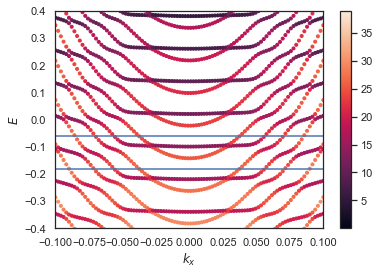

In [398]:
plt.scatter(ks_floquet, Es_floquet, marker='.', c=pos_floquet)
plt.colorbar()

a0 = eE0/(hbar*Omega)
Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
plt.axhline(30.4*a0**2 - mu)
plt.axhline(30.4*a0**2 - mu + hbar*Omega)
plt.ylabel(r"$E$")
plt.xlabel(r"$k_x$")
plt.ylim(-0.4,0.4)
plt.xlim(-0.1,0.1)
plt.show()

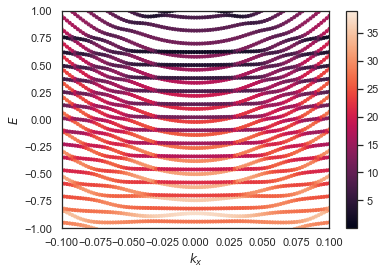

In [385]:
plt.scatter(ks_floquet, Es_floquet, marker='.', c=pos_floquet)
plt.colorbar()

a0 = eE0/(hbar*Omega)
Eeff = np.sqrt((hbar*Omega/2)**2 + (a0*3.33)**2)
# plt.axhline(30.4*a0**2 - mu)
# plt.axhline(30.4*a0**2 - mu + hbar*Omega)
plt.ylabel(r"$E$")
plt.xlabel(r"$k_x$")
plt.ylim(-1,1)
plt.xlim(-0.1,0.1)
plt.show()

## Plot with low-energy expansions

In [444]:
A2_low = 5.33
D2_low = 30.4

ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=1,A2=A2_low,D2=D2_low,mu=0.3,eE0=eE0*1.,Omega=Omega)


In [457]:
ks_band = np.linspace(-0.1,0.1,1000)
a0 = eE0/(hbar*Omega)
# ands are adjusted for +mu/hbar
w1_band = (D2_low*a0**2-mu+hbar*Omega/2-np.sqrt((a0*A2_low)**2+(hbar*Omega/2)**2) + (-2*a0**2*A2_low**2-2*a0**4*D2**2-hbar*Omega**2+3*a0**2*D2*np.sqrt(4*a0**2*A2_low**2+hbar*Omega**2)/(a0**2*np.sqrt(4*a0**2*A2_low**2+hbar*Omega**2)))*ks_band**2)/hbar
w2_band = (D2_low*a0**2-mu+(hbar*Omega-D2_low*a0**2)/a0**2*ks_band**2)/hbar
w3_band = (D2_low*a0**2-mu+hbar*Omega-(hbar*Omega+D2_low*a0**2)/a0**2*ks_band**2)/hbar
w4_band = (D2_low*a0**2-mu+hbar*Omega/2+np.sqrt((a0*A2_low)**2+(hbar*Omega/2)**2) + (2*a0**2*A2_low**2+2*a0**4*D2**2+hbar*Omega**2+3*a0**2*D2*np.sqrt(4*a0**2*A2_low**2+hbar*Omega**2)/(a0**2*np.sqrt(4*a0**2*A2_low**2+hbar*Omega**2)))*ks_band**2)/hbar


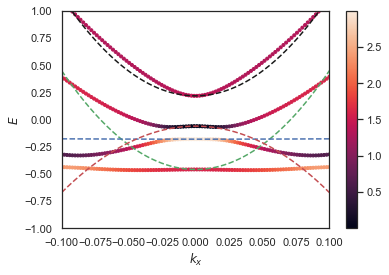

In [458]:
plt.scatter(ks_floquet, Es_floquet, marker='.', c=pos_floquet)

plt.plot(ks_band, w1_band*hbar, c='g',ls='--')
plt.plot(ks_band, w2_band*hbar, c='b',ls='--')
plt.plot(ks_band, w3_band*hbar, c='r',ls='--')
plt.plot(ks_band, w4_band*hbar, c='k',ls='--')


plt.colorbar()

plt.ylabel(r"$E$")
plt.xlabel(r"$k_x$")
plt.ylim(-1,1)
plt.xlim(-0.1,0.1)
plt.show()

## Plot of photocurrent with 4 band model over it

In [157]:
P_4 = PhotocurrentArrayWK(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=-0,A2=5.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

In [158]:
ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=1,A2=5.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega)


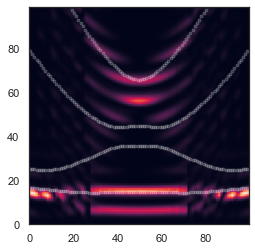

In [159]:
%matplotlib inline 
plt.imshow(P_4.T)

plt.scatter(coord_to_res(ks_floquet,0.1,-0.1,100),coord_to_res(Es_floquet/hbar,1,-1,100),marker='.',c='white',alpha=0.2)

plt.ylim(0,99)
plt.show()

# Chern number and Berry stuff

In [35]:
import floquet_berry as fb

In [85]:
ms = 1
bands = int(4*ms)
for i in range(bands):
    C = fb.ChernNumber(res=100,band=i,ms=ms,A2=5.33,D2=30.4,mu=mu,eE0=eE0,Omega=Omega)
    print("C_{} = {}".format(i,C))

# fb.ChernNumber(res=100,band=0,A2=5.33,D2=0.,mu=mu,eE0=eE0,Omega=Omega)

C_0 = 2.297067269945873e-16
C_1 = 1.4135798584282297e-16
C_2 = 5.300924469105862e-16
C_3 = 2.694636605128813e-16


Compute Berry curvature near the flat band -- it is not appropriate to simply extend periodically (we can accidentally double count the Berry poles)

# Different ways to drive

In [227]:
# make a general function where one can change the drive
# function f in dt{psi} = f(t,psi)
def dirac_flip(t,psi,kx,ky,A2,D2,mu,eE0,Omega,Tpump):
    # get t reduced to set the "mass"
#     T = 2*np.pi/Omega
#     t_dim = t%T
#     if t_dim < T/2:
#         m = 0.2 * s3 # choice of size and of spin structure
#     else:
#         m = 0 * s3
        
    # Bsin(Omega*t)
    m = 0.1 * np.sin(Omega*t) * s0
    
    H_bump = m * np.exp(-t**2/(2*Tpump**2))
    
    # get H
    H = Hbite(kx,ky,A2,D2,mu) + H_bump
    # return schrodinger
    f = -1j/hbar * H @ psi
    return f

def PhotocurrentArrayEnergyFlip(res_w,w_range,kx,ky,t0,A2,D2,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(-w_range,w_range,res_w) #- mu/hbar #np.linspace(-np.pi,np.pi,res_w)*Omega - mu/hbar # from inverting (w-wF)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions(kx,ky,A2,D2,mu)

    # solve the dirac equation
    # the bounds in time are set by taking ts beyond the largest time scales
    psi_plus = solve_ivp(fun=dirac_flip, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,A2,D2,mu,eE0,Omega,Tpump), method='RK45')
    psi_minus = solve_ivp(fun=dirac_flip, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,A2,D2,mu,eE0,Omega,Tpump), method='RK45')

    # compute Photocurrent
    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent(psi_plus=psi_plus,psi_minus=psi_minus,Es=Es,kx=kx,ky=ky,w=w,t0=t0,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [228]:
ws5, Ps5 = PhotocurrentArrayEnergyFlip(res_w=300,w_range=1,kx=0.0,ky=0,t0=-500,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1, Ps1 = PhotocurrentArrayEnergyFlip(res_w=300,w_range=1,kx=0.0,ky=0,t0=-100,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws0, Ps0 = PhotocurrentArrayEnergyFlip(res_w=300,w_range=1,kx=0.0,ky=0,t0=0,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

<IPython.core.display.Javascript object>


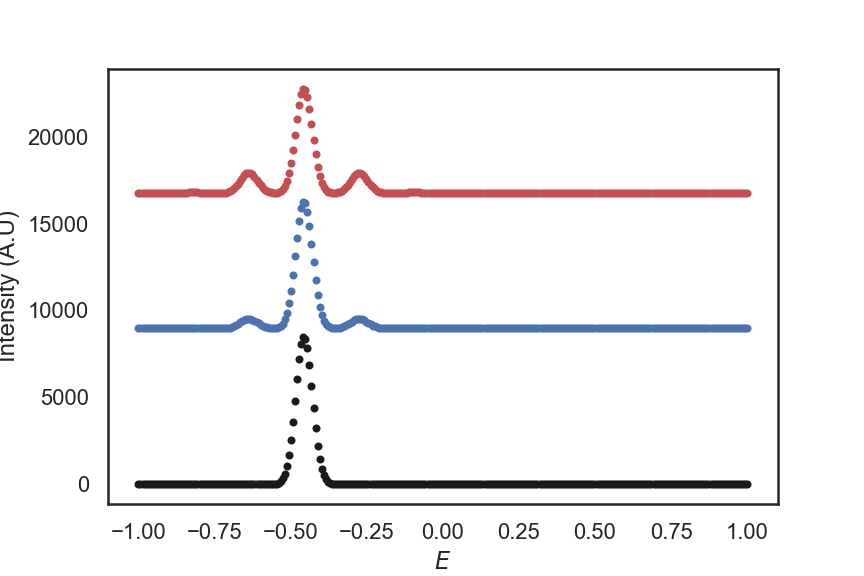

In [229]:
%matplotlib notebook
# plot it
plt.figure()

plt.scatter(ws5,Ps5,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5) + 500

plt.scatter(ws1,Ps1+shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1) + 500

plt.scatter(ws0,Ps0+shift2,c='r',marker='.',label=r"$t_0 = 0$")

# plt.legend()
# plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.xlabel(r"$E$")
plt.ylabel(r"Intensity (A.U)")
# plt.xlim(-1,1)
plt.show()

In [230]:
def PhotocurrentArrayWKFlip(k_dir,k_other,k_range,w_range,t0,A2,D2,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 100
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(-k_range,k_range,res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyFlip(res_w=res_w,w_range=w_range,kx=kx,ky=k_other,t0=t0,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
            
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergyFlip(res_w=res_w,w_range=w_range,kx=k_other,ky=ky,t0=t0,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
        
    return P

In [231]:
P = PhotocurrentArrayWKFlip(k_dir=1,k_other=0,k_range=0.1,w_range=1,t0=0,A2=3.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

In [232]:
%matplotlib notebook
plt.imshow(P.T)
plt.xticks([coord_to_res(-0.1,0.1,-0.1,100),coord_to_res(-0.,0.1,-0.1,100),coord_to_res(0.1,0.1,-0.1,100)],labels=[r"$-0.1$",r"$0$",r"$0.1$"])
plt.yticks([coord_to_res(-1,1,-1,100),coord_to_res(0,1,-1,100),coord_to_res(1,1,-1,100)],labels=[r"$-1$",r"$0$",r"$1$"])
plt.ylabel(r"$\omega$")
plt.xlabel(r"$k_x$")
plt.ylim(0,99)
plt.show()

<IPython.core.display.Javascript object>

# Floquet unitary stuff

# Effective surface theory trick?

In [243]:
def Heff(kx,ky,A2,D2,mu,eE0,Omega):
    """
    Floquet Hamiltonian 4x4 with flat band at zero energy at gamma point
    """
#     # set a0
#     a0 = eE0/(hbar*Omega)
        
#     # make diagonals
#     H0 = D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1)
    
#     # other term
#     H1 = D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1) + hbar*Omega
    
#     # make off-diagonals
#     off_diag = -D2*a0*(kx-1j*ky)*s0 - 1j*a0/2*A2*(s1-1j*s2)
    
#     H = H0 - off_diag.conj().T @ np.linalg.inv(H1) @ off_diag
    
    
    H_full = Hfloquet(ms=2,kx=kx,ky=ky,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
    
    H0 = H_full[6:8,6:8]
    H1 = H_full[0:6,0:6]
    
    T = H_full[0:6,6:8]
    T_dag = H_full[6:8,0:6]
    
    H = H0 - T_dag @ np.linalg.inv(H1) @ T
        
    return H

def spectrum_3DTI_open_eff(k_dir,k_other,A2,D2,mu,eE0,Omega):
    res = 100
    
    s = 2

    ks = np.linspace(-0.1,0.1,res)
    Es = np.zeros(s*res)
    pos = np.zeros(s*res)
    
    if k_dir==1:
        for i in range(res):
            k = ks[i]
            H = Heff(kx=k,ky=k_other,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
            E, W = np.linalg.eigh(H)
            ps = Position(W,size=s)
            Es[i*s:(i+1)*s] = E
            pos[i*s:(i+1)*s] = ps
            
    elif k_dir==2:
        for i in range(res):
            k = ks[i]
            H = Heff(kx=k_other,ky=k,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
            E, W = np.linalg.eigh(H)
            ps = Position(W,size=s)
            Es[i*s:(i+1)*s] = E
            pos[i*s:(i+1)*s] = ps


    ks_ret = np.repeat(ks,s)
    
    return ks_ret,Es,pos

def Geff(w,kx,ky,A2,D2,mu,eE0,Omega):
    """
    Floquet Hamiltonian 4x4 with flat band at zero energy at gamma point
    """
#     # set a0
#     a0 = eE0/(hbar*Omega)
        
#     # make diagonals
#     H0 = D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1)
    
#     # other term
#     H1 = D2*(kx**2+ky**2+a0**2)*s0 + A2*(kx*s2-ky*s1) + hbar*Omega
    
#     # make off-diagonals
#     off_diag = -D2*a0*(kx-1j*ky)*s0 - 1j*a0/2*A2*(s1-1j*s2)
    
#     H = H0 - off_diag.conj().T @ np.linalg.inv(H1) @ off_diag
    
    
    H_full = Hfloquet(ms=2,kx=kx,ky=ky,A2=A2,D2=D2,mu=mu,eE0=eE0,Omega=Omega)
    
    H0 = H_full[6:8,6:8]
    H1 = H_full[0:6,0:6]
    
    T = H_full[0:6,6:8]
    T_dag = H_full[6:8,0:6]
    
    Geff = np.linalg.inv(w*s0 - H0 - T_dag @ np.linalg.inv(w*np.eye(6) - H1) @ T)
        
    return Geff

def FullSpectralFunctionWK(res,wrange,kx,ky,A2,D2,mu,eE0,Omega):
    """
    Return array for plot as a function of energy and momentum
    """
    # set up arrays
    ws = np.linspace(-wrange,wrange,num=res)

    As = np.zeros((res),dtype=float)

    # loop over them
    for i in range(len(ws)):
        w = ws[i] + 1j * 0.05
        A = -1/np.pi * np.trace(np.imag(Geff(w,kx,ky,A2,D2,mu,eE0,Omega)))
        As[i] = A

    return As



In [244]:
res = 100
kxs = np.linspace(-0.1,0.1,res)
As = np.zeros((res,res),dtype=float)

for i in range(res):
    kx = kxs[i]
    As[:,i] = FullSpectralFunctionWK(res=res,wrange=1,kx=kx,ky=0,A2=5.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega)

In [252]:
ks_floquet, Es_floquet, pos_floquet = spectrum_3DTI_open(k_dir=1,k_other=0,ms=10,A2=5.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega)


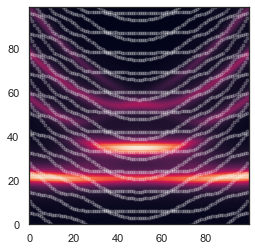

In [253]:
%matplotlib inline

plt.imshow(As)

plt.scatter(coord_to_res(ks_floquet,0.1,-0.1,100),coord_to_res(Es_floquet/hbar,1,-1,100),marker='.',c='white',alpha=0.2)

plt.ylim(0,res-1)
plt.show()

In [235]:
ks_floquet_eff, Es_floquet_eff, pos_floquet_eff = spectrum_3DTI_open_eff(k_dir=1,k_other=0,A2=5.33,D2=30.4,mu=0.3,eE0=eE0,Omega=Omega)


<IPython.core.display.Javascript object>


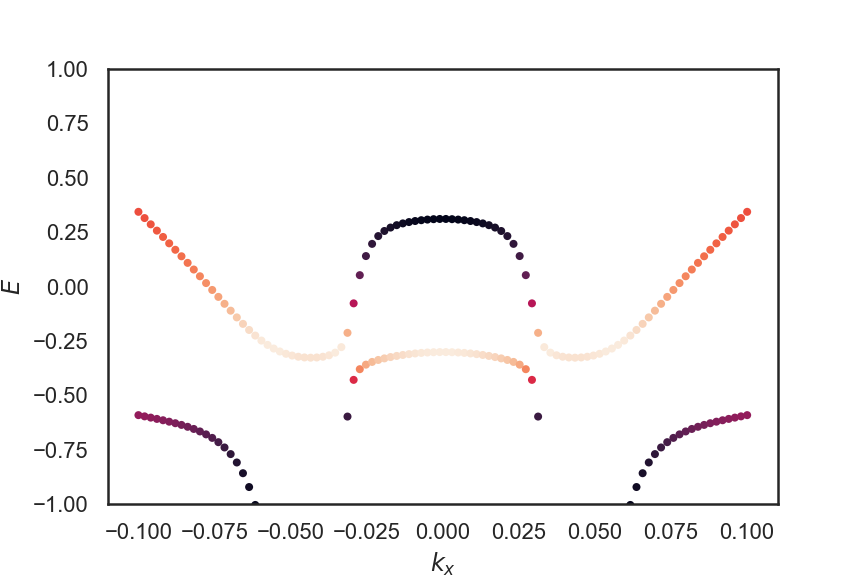

In [237]:
%matplotlib notebook
plt.scatter(ks_floquet_eff, Es_floquet_eff,c=pos_floquet_eff,marker='.')
plt.xlabel("$k_x$")
plt.ylabel("$E$")
plt.ylim(-1,1)
plt.show()

# $\mathcal{O}\left(\mathbf{k}^3\right)$ corrections and arbitrary model with bumps